In [1]:
# Chapter 02 - More PyMC

In [2]:
# Typical imports
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import theano.tensor as tt

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# Incorporate the custom `matplotlib` styles
import json
from cycler import cycler

# noinspection SpellCheckingInspection
s = json.load(open('./styles/bmh_matplotlibrc.json'))
s['axes.prop_cycle'] = cycler('color', s['axes.prop_cycle']['color'])
matplotlib.rcParams.update(s)

In [4]:
# Create a color cycle
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

## A little more PyMC3

### Model context

In PyMC3, we put all variables of interest in the context of a `Model`.

In [5]:
with pm.Model() as model:
    parameter = pm.Exponential('poisson_param', lam=1.0)
    data_generator = pm.Poisson('data_generator', parameter)

We can continue to work within the context of a previously defined `Model` instance by using `with` and the name
of the previously defined variable referring to the `Model` instance.

In [6]:
with model:
    data_plus_one = data_generator + 1

Even though we have defined variables in the context of a model, we can access these variables **outside** the
model context.

In [7]:
parameter.tag.test_value

array(0.69314718)

The first parameter to all model variables is its name. This name allows PyMC3 to access the variable name later.

Additionally, one can define a new variable with a previously used name in a different model.

In [8]:
with pm.Model() as model:
    theta = pm.Exponential('theta', 2.0)
    data_generator = pm.Poisson('data_generator', theta)

We are free to name our model variables whatever we wish. Remember, reusing a model variable name results in
overwriting the previous model.

In [9]:
with pm.Model() as ab_testing:
    p_A = pm.Uniform('P(A)', 0, 1)
    p_B = pm.Uniform('P(B)', 0, 1)

### PyMC3 Variables

All PyMC3 variables have an initial value (that is, a test value). Examining the variables previously defined:

In [10]:
print(f'{parameter.tag.test_value=}')
print(f'{data_generator.tag.test_value=}')
print(f'{data_plus_one.tag.test_value=}')

parameter.tag.test_value=array(0.69314718)
data_generator.tag.test_value=array(0, dtype=int64)
data_plus_one.tag.test_value=array(1, dtype=int64)


The `test_value` is used only for the model to provide a starting point for sampling if no other starting point
is specified.

It will **not** change as a result of sampling; however, the initial state can be changed by specifying a value
for the `testval` parameter when creating the variable.

Specifying `testval` can be helpful if you are using a more unstable prior that may require a better starting
point for sampling.

In [11]:
with pm.Model() as model:
    parameter = pm.Exponential('poisson_param', 1.0, testval=0.5)

In [12]:
parameter.tag.test_value

array(0.5)

In [13]:
with pm.Model() as variable_model:
    # Stochastic variables have a name and other parameters specific to the distribution.
    # It is best to ues a description value for `name` since this value will be used to retrieve the
    # posterior distribution for subsequent analysis.
    some_variable = pm.DiscreteUniform('discrete_uniform_variable', 0, 4)

    # One can use the `shape` argument to model a multivariate (independent) stochastic variable.

    # Additionally, one can use the `shape` argument to handle the "annoying" case in which you wish
    # to model a sequence of values drawn from a single distribution that only differ by "index."
    # For example, instead of
    # beta_1 = pm.Uniform('beta_1', 0, 1)
    # beta_2 = pm.Uniform('beta_2', 0, 1)
    # ...
    #
    # One can wrap them in a single variable:
    N = 7
    betas = pm.Uniform('betas', 0, 1, shape=N)

    # The other category are deterministic variables. We can create a deterministic variable using the
    # `Deterministic` constructor.
    def some_function_of_other_variables(some_variable, betas):
        return some_variable + betas.mean()
    #
    # deterministic_variable = pm.Deterministic('deterministic variable', some_function_of_other_variables)
    # Note that the previous, commented out code generates an `AttributeError` about a `copy` attribute.
    # Based on other issues, I believe that the latest versions of PyMC3 no longer support `Deterministic`
    # as we used it above.

In [14]:
# Using the `Deterministic` constructor is the most obvious way to create a deterministic variable; however,
# elementary operations like addition and exponentiation implicitly create deterministic variables.
# For example:
with pm.Model() as model:
    lambda_1 = pm.Exponential('lambda_1', 1.0)
    lambda_2 = pm.Exponential('lambda_2', 1.0)
    tau = pm.DiscreteUniform('tau', lower=0, upper=10)

new_deterministic_variable = lambda_1 + lambda_2

# Remember, to use a deterministic variable in a model, one must use the `Deterministic` constructor.

In [15]:
# We can define a deterministic variable inside a model context:
n_data_points = 5  # We had 70 data points in chapter 01.
idx = np.arange(n_data_points)
with model:
    lambda_ = pm.math.switch(tau >= idx, lambda_1, lambda_2)

### Theano

In [16]:
with pm.Model() as theano_test:
    p1 = pm.Uniform('p', 0, 1)
    p2 = 1 - p1
    p = tt.stack([p1, p2])

    assignment = pm.Categorical('assignment', p)

### Including observations in the model

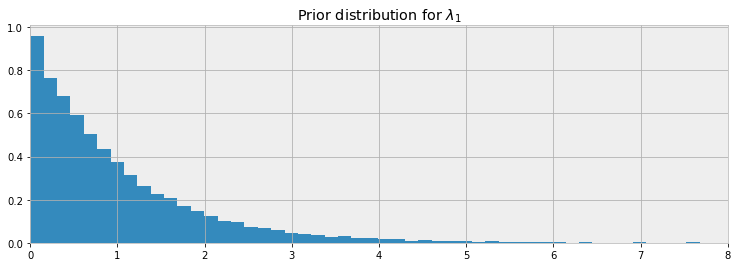

In [17]:
plt.figure(figsize=(12.5, 4))

samples = lambda_1.random(size=20000)
plt.hist(samples, bins=70, density=True, histtype='stepfilled')
plt.title('Prior distribution for $\lambda_1$')
plt.xlim(0, 8)

plt.show()

In [18]:
data = np.array([10, 5])
with model:
    fixed_variable = pm.Poisson('fxd', 1, observed=data)
print(f'{fixed_variable.tag.test_value}')

[10  5]


In [19]:
# Were using fake data here
data = np.array([10, 25, 15, 20, 35])
with model:
    obs = pm.Poisson('obs', lambda_, observed=data)
print(f'{obs.tag.test_value}')

[10 25 15 20 35]


## Modeling Approaches

A good approach to Bayesian modeling is to think about _how your data might have been generated_.

From the text message count in the last chapter:

1. Began: "What is the best way to describe the count data?" Our answer: our data was sampled from a
   Poisson distribution.
2. But a Poisson distribution is characterized by a parameter, $\lambda$.
3. Do we know $\lambda$? No. In fact, we think our process may have **two** $\lambda$ values: one for earlier
   behavior and one for later behavior. However, we do not know when the switch occurs, but let's posit that
   that switch occurs at time $\tau$.
4. What is a good distribution for the two $\lambda$s? Since $\lambda$ can take on any non-negative real number,
   we want a distribution whose support is the non-negative real numbers. An exponential distribution is a
   distribution with such support. But an exponential distribution takes its own parameter, $\alpha$.
5. What do we know about $\alpha$. Not very much. We might estimate that each $\lambda$ is between 10 and 30,
   but we are not very confident. Rather than choose a distribution for $\alpha$, we wil simply estimate
   a value. But what value, we want to neither be too low nor too high, so we choose $\alpha$ equal to the
   inverse of mean of the counts per day.
6. We have no expert opinion on $\tau$ so we choose to simple from a discrete uniform distribution.

### Same story; different endings

As advantage of identifying a generative model is that we can run the process "backwards"; that is, we can
sample values from our generative distribution(s). Eventually, having sampled parameters from all our processes,
we can actually simulate the observed data to ensure that the simulated observed data has similar characteristics
to the actual observed data.

In [20]:
# Since `tau` is a leaf of our variable tree, begin by sampling `tau`.
tau = np.random.randint(0, 80)
# tau = stats.randint(0, 80)  # an alternative
print(f'{tau=}')

tau=69


In [21]:
# We next draw `lambda_1` and `lambda_2` from an exponential distribution.
alpha = 1. / 20.
lambda_1, lambda_2 = np.random.exponential(scale=(1 / alpha), size=2)
# lambda_1 = stats.expon(alpha=alpha)  # an alternative
# lambda_2 = stats.expon(alpha=alpha)
print(f'{lambda_1=}, {lambda_2=}')

lambda_1=15.49388257684866, lambda_2=39.244357028011684


In [22]:
# Finally, we generate the count data from a Poisson distribution
simulated = np.r_[stats.poisson.rvs(lambda_1, size=tau), stats.poisson.rvs(lambda_2, size=80 - tau)]

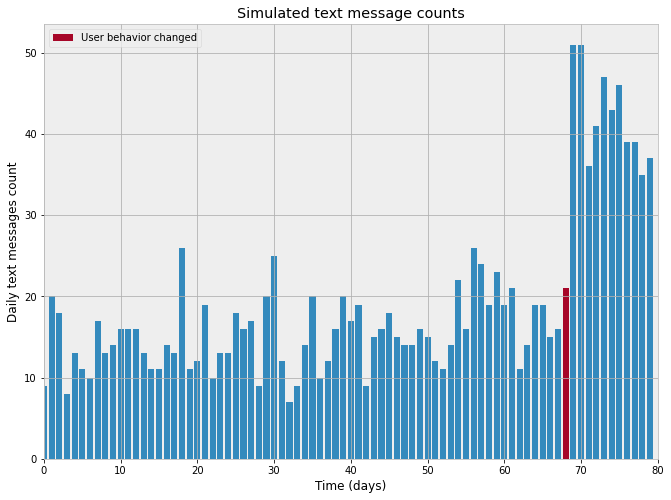

In [23]:
# Finally, plot the generated (simulated) data
fig, ax = plt.subplots(figsize=(11, 8))
ax.bar(np.arange(80), simulated, color=color_cycle[0])
ax.bar(tau - 1, simulated[tau - 1], color=color_cycle[1], label='User behavior changed')

plt.xlim(0, 80)
plt.xlabel('Time (days)')
plt.ylabel('Daily text messages count')
plt.legend()
plt.title('Simulated text message counts')
plt.show()

Note that this data does not look identical (or even close) to our observed count data. However, it does have
similar characteristics:

- Two different regimes
- Separated at $\tau$

(The writer also discovered that **some** simulations may generate a count of zero (0) on day $\tau$.)

In [24]:
# We simulate a few more data sets below
def plot_simulated_sms_dataset(ax, color):
    tau = stats.randint.rvs(0, 80)
    alpha = 1. / 20.
    lambda_1, lambda_2 = stats.expon.rvs(scale=(1. / alpha), size=2)
    simulated = np.r_[stats.poisson.rvs(mu=lambda_1, size=tau), stats.poisson.rvs(mu=lambda_2, size=(80 - tau))]
    ax.bar(np.arange(80), simulated, color=color)
    ax.bar(tau - 1, simulated[tau - 1], color='y', label='User behavior changed')

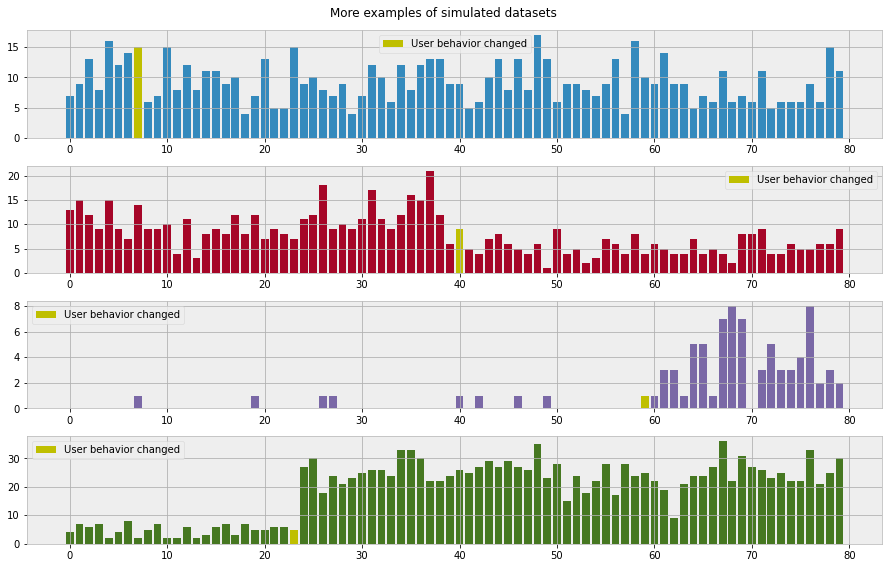

In [25]:
_, axes = plt.subplots(4, 1, figsize=(12.5, 8))
for i in range(4):
    ax = axes[i]
    plot_simulated_sms_dataset(ax, color_cycle[i])
    ax.legend()
plt.suptitle('More examples of simulated datasets')
plt.tight_layout()

Later, we will see how to use simulations to make predictions and test the appropriateness of our models.

### Example: Bayesian A/B Testing

A statistical design pattern for determining the difference of effectiveness between two different treatments. For example, a pharmaceutical company is interested in the effectiveness of drug A versus drug B. Similarly, front-end web developers are interested in which design of their website yields more sales or some other metric of interest. They will route some fraction of traffic to site A and the remainder to site B, and then record  if the visit yielded a sale or not.

### A Simple Case

We'll continue with the web developer example. We begin by focusing on site A only.

We assume that some true probability, $0 \le p_A \le 1$, that users who, encountering site A, eventually make a purchase from the site. This quantity is the true effectiveness of site A; however, the actual value, $p_A$, is unknown to us.

One might assume that, out of $N$ people who visit site A, if $n$ people make a purchase, that the effectiveness of site A is $\frac{n}{N}$. However, this value is the _observed frequency_ not the true effectiveness. Even though $\frac{n}{N}$ is not the true frequency, we can use this observed data to **infer** the true effectiveness of site A.

In our situation, we want to use the observed data, $N$, the total number of visitors to site A, and $n$, the number of visitors that made a purchase from site A, to estimate $p_A$, the true frequency of buyers; that is, the true effectiveness of site A.

To set up a Bayesian model, we need to assign prior probabilities to our unknown quantities. _A priori_, what do we think $p_a$ might be? For this example, we have no strong convictions about $p_A$. This suggests using a uniform distribution.

In [33]:
with pm.Model() as model:
    p = pm.Uniform('p', lower=0, upper=1)

If we had stronger prior beliefs, for example, if already had a "base rate" for sales, we might choose a different prior.

For this example, we can simulate our observed data. Specifically, if one assumes that $p_A$ is 0.05 and that $N$ is 1500 users shown site A, we can use a Bernoulli distribution to simulate the number of "successes" in 1500 trials with a probability of success on each trial of 0.05.

In [34]:
p_true = 0.05  # Actually unknown. Assume this value to simulate observed data
N = 1500

# Generate the simulated data
occurrences = stats.bernoulli.rvs(p_true, size=N)

print(occurrences)  # Remember that Python treats `True == 1` and `False == 0`
print(np.sum(occurrences))  # The number of "successes."

[0 0 0 ... 0 0 0]
74


In [35]:
# The mean of `occurrences` is equal to `n / N`.
print(f'What is the observed frequency of sales from site A? {np.mean(occurrences):.4f}')
print(f'Does the observed frequency equal the true frequency? {np.mean(occurrences) == p_true}')

What is the observed frequency of sales from site A? 0.0493
Does the observed frequency equal the true frequency? False


We use the simulated data in our `observed` variable, and run our inference algorithm:

In [36]:
# Include the observations which are Bernoulli trials
with model:
    obs = pm.Bernoulli('obs', p, observed=occurrences)
    # Incantation to be explained later
    step = pm.Metropolis()
    trace = pm.sample(10000, step=step, return_inferencedata=False)
    burned_trace = trace[1000:]  # skips the first 1000 samples in the trace (the tuning steps?)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [p]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 41 seconds.
The number of effective samples is smaller than 25% for some parameters.


We plot the posterior distribution for the unknown $p_A$.

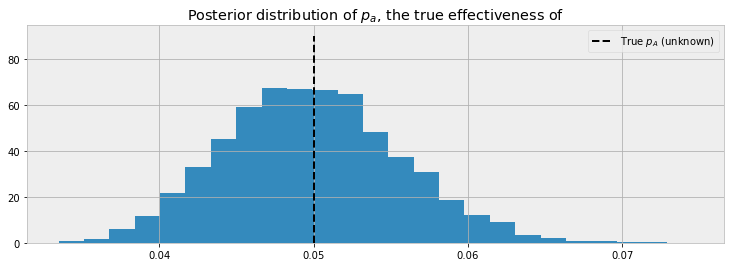

In [39]:
_, ax = plt.subplots(figsize=(12.5, 4))
ax.hist(burned_trace['p'], bins=25, histtype='stepfilled', density=True)
ax.vlines(p_true, 0, 90, linestyle='--', color='k', label='True $p_A$ (unknown)')
plt.title('Posterior distribution of $p_a$, the true effectiveness of ')
plt.legend()
plt.show()

Notice that our posterior distribution puts most of the weight **near** the true value of $p_A$, 0.05, but also puts significant weight in the tails of the distribution.

Try changing the value of $N$ and see how the posterior changes.

In [ ]:
# Insert code here
assert False

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 51 seconds.


array([[<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>]], dtype=object)

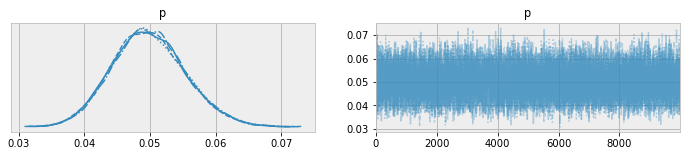

In [43]:
# Try a similar exercise using `arviz`
with pm.Model() as arviz_model:
    p = pm.Uniform('p', lower=0, upper=1)
    obs = pm.Bernoulli('obs', p, observed=occurrences)
    # Incantation to be explained later
    idata = pm.sample(10000, return_inferencedata=True)

az.plot_trace(idata)